 # Lesson Bayes
 Rev 2.1: 2-27-22

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from scipy import stats

# Lesson: Bayes Deep Dive

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

In this lesson were going to focus on Bayes Theorem itself

<img src="img/BayesianUpdate.png" width="1200">

Remember this slide from the earlier lesson. In this lesson we're going cover everything on this slide, and more

## Breaking down the A/B Test model

In [11]:
# Generate random data to see if we can recover parameters in this lesson
np.random.seed(3)
n_visitors = 1000
conversion_rate=.3

# Simulate 286 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

with pm.Model():
    
    # Parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    
    # Likelihood of observing data given parameter
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # Posterior Estimation
    idata = pm.sample()
    
    # Prior Predictive
    idata.extend(pm.sample_prior_predictive())
    
    # Posterior Predictive
    idata.extend(pm.sample_posterior_predictive(idata))
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We're going to do that by breaking down the AB testing model that you're oh so familiar with. We'll dive into detail in what every single line is doing in this model and code

## Prior Distribution
* How we incorporate domain knowledge
* Regularization for Bayesian Models


## Likelihood Distribution
* The measure of observation plausibility
* The connection between the data space and parameter space

## Posterior Distribution
* The distribution every Bayesian is seeking
* Our updated beliefs after incorporating the data

## Prior Predictive and Posterior Predictive distributions
  * From parameter space to data space
  * Two types
      * Prior Predictive
      * Posterior Predictive

## Markov Chain Monte Carlo
* Magic Inference Button TM
* The computational sampling algorithm that makes Modern Bayes possible
    * This is the core of the magic machine


Specifically we're going to go through each one of these terms and talk through the their theoretical meaning and their practical intuition

# Priors
Expressing plausibility before seeing data

$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{{p(\boldsymbol{Y})}}
$$

<img src="img/PriorSlide.png" width="1200">

## Expressing a prior in PyMC

In [ ]:
# with pm.Model() as model_a:
    
    # Parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

You've seen this many times now, in PyMC we express the prior by picking a distribution and parameterizing it. We've been using the Beta for conversion rate. Later on you'll see the others like Normal and Half Normals as well

## Priors distributions codify expert knowledge
Each of these distributions showcase a different belief

## A/B Testing: What do we know before we see the data?


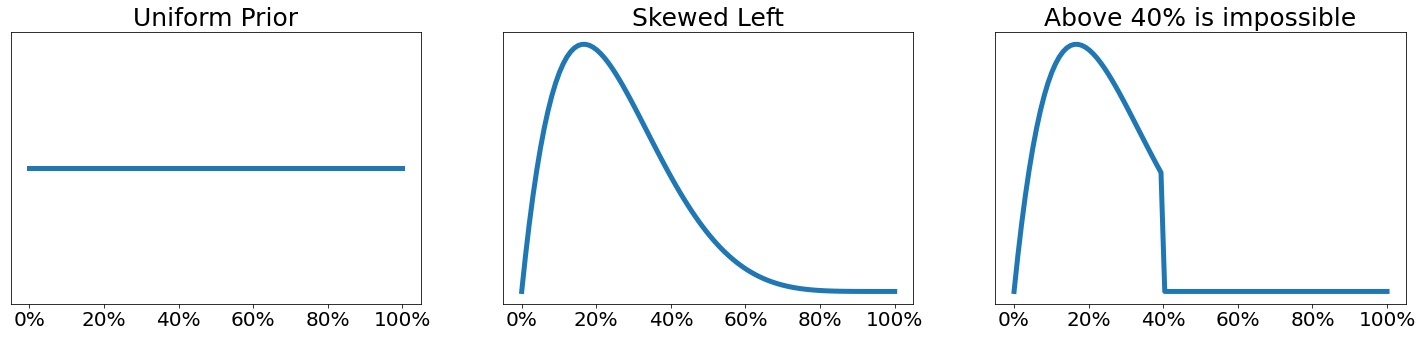

In [91]:
import matplotlib.ticker as mtick

def priors(labels):
    fig, axes = plt.subplots(1, 3, figsize=(25,5))

    x = np.linspace(0,1,100)

    unif = stats.uniform(0,1)
    axes[0].plot(x, unif.pdf(x), lw=5)
    axes[0].set_title(labels[0], fontsize=25)

    beta = stats.beta(2,6)
    axes[1].plot(x, beta.pdf(x), lw=5)
    axes[1].set_title(labels[1], fontsize=25)


    truncated = stats.beta(4,12)
    pdf = beta.pdf(x)
    pdf[x>.4] = 0
    axes[2].plot(x, pdf, lw=5)
    axes[2].set_title(labels[2], fontsize=25)

    for ax in axes:
        ax.set_yticks([])
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.tick_params(axis="x", labelsize=20)
    return 

labels = ["Uniform Prior", "Skewed Left", "Above 40% is impossible"]
priors(labels)

Before running the experiment what do we believe the conversion ratio could be?

* Any value between 0% and 100% equally?
* Probably 20% based on past experience?
* Definitely not above 40%?
You may be now thinking "Well how do I know the right/best/correct prior?" The truth is you won't.

There's a famous quote stating "All models are wrong, some are useful"

When selecting priors the task is not to pick the right prior *independent of any other factor*, but one that you can justify in context with
* the rest of the model
* how your model will be used in reality
* the experience of domain experts

## Priors are a form of regularization
<img src="img/PriorRegularization.png" width="1200">

Another benefit of priors is they can be utilized to focus the models on reasonable possibilities and not far flung parameters that happen optimize a metric.

In other words we can use priors to
* Highlight reasonable possible parameters
* Penalize unreasonable possible parameters

A great example is in medical data. Collecting lots of data is either impossible or unethical, but through years of experience doctors have a great sense of what reasonable numbers should be. By expressing this knowledge in priors they downweighting unreasonable or impossible answers, and letting the model focus on answers within the span of believability.

You saw this in our AB test model, we didn't know exactly what the conversion rate was, but we knew numbers below 50% were the most likely. The once we incorporated the data the posterior became much more concentrated around 30%. Its the exact same idea

## Section Recap
* Priors distributions express the plausibility of parameters prior to seeing data
* Priors serve as a form of regularization
* When choosing a prior focus on the rationale behind the prior


# Likelihoods
The plausibility of the data given a parameter  


$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{Likelihood}}\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

<img src="img/LikelihoodSlide.png" width="1200">

# The connection between data space and parameter space

```python
likelihood = pm.Binomial("likelihood", 
                            p=conversion_rate, 
                            n=n_visitors,
                            observed=observed_conversions)
```

## Ranking possible conversion values?
For our A/B test example let's say we on variant B we see *100* visits and *85* of them convert.

What is the plausibility that the true conversion rate, p(conversion) is:
* 1%
* 100%
* 80%
* 95%

Pause the video here and rank these from most to least plausible before continuing on

## Intuitively ranking `p(conversion)` values?

1. 80%
2. 95%
3. 1%
4. 100%



Out of 100 visits, 85 converted. That brings us to an *empirical* conversion rate of 85%, but as Bayesians we also want to know the plausibility of all other conversion rates.

Intuitively we know a 100% conversion rate impossible. If even 1 person didn't convert the true conversion rate can't be 100%.

1% is highly implausible but *it is still possible*. It may be that in our sample of 100 we were lucky to get 85, but it's not likely.

Intuition may not be enough to differentiate  80% and 95%, let's show how to calculate likelihood

## Calculating Likelihood is just calculating PMF (or PDF)

In [14]:
num_conversions, num_visitors = 85, 100
possible_true_conversion_rate = .80

binom = stats.binom(p=possible_true_conversion_rate, n=num_visitors)
binom.pmf(num_conversions)

0.0480617937007464

The calculation for a likelihood is just calculating the PDF! We plug in a possible conversion value, and the data and we get a value back.

Remember though that the PMF, or PDF, values only mean something relative to each other. We need to compare our likelihood at 80% with the one at 95%



## Comparing Relative Likelihoods


In [15]:
multiple_possible_true_conversion_rates = [.01, .8, .95, 1]

binom = stats.binom(p=multiple_possible_true_conversion_rates, n=num_visitors)
likelihoods = binom.pmf(num_conversions)
pd.DataFrame({"possible_conversion_date":multiple_possible_true_conversion_rates,
              "calculated_likelihood":likelihoods})

,possible_conversion_date,calculated_likelihood
0,0.01,2.178859e-153
1,0.80,4.806179e-02
2,0.95,9.880016e-05
3,1.00,0.000000e+00


The results match our intuition. 100% conversion is impossible, given a value of zero, 1% is highly unlikely, and comparing 80% and 95%, 80% is more likely

This is great, now we have a way of quantifying the plausibility of the observed data given a parameter.

Let's use a handy trick from SciPY where we can plug in all four parameter values and calculate the likelihood in one go.

## What is the most plausible line?


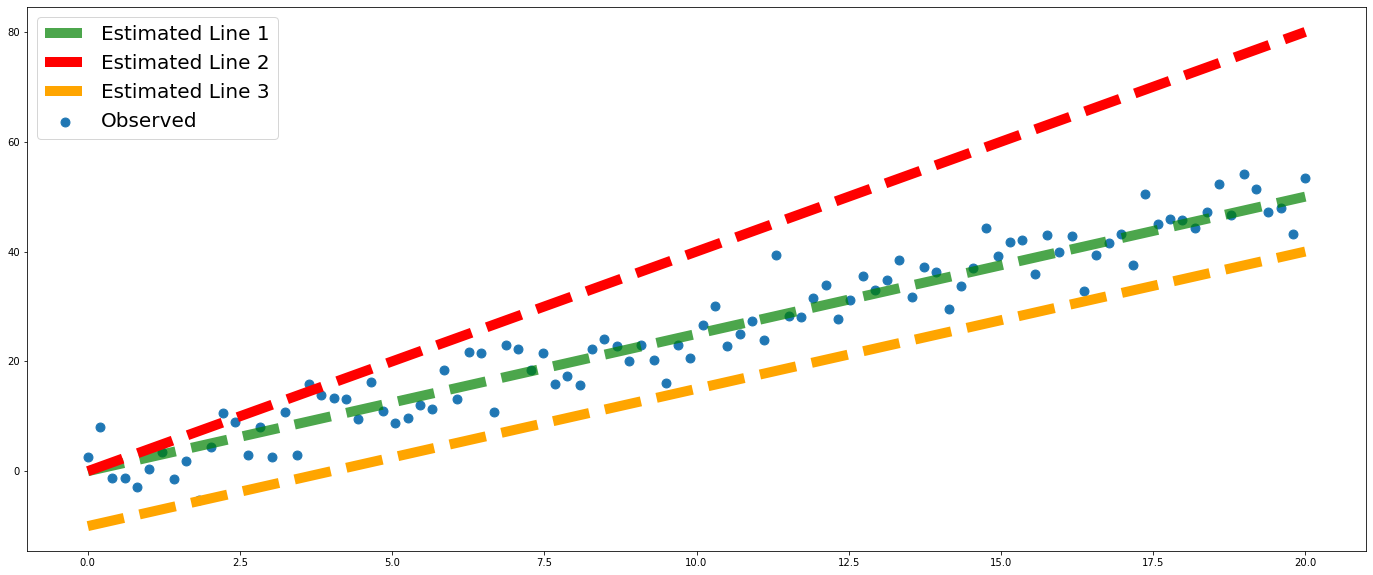

In [115]:
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)
x = np.linspace(-0, 20, 100)
slope_true = 2.5

y_obs = x * slope_true + stats.norm(0, 4).rvs(100)

fig, ax = plt.subplots(figsize=(24, 10))

lw = 10
ax.plot(x, slope_true * x, c="g", lw=lw, ls="--", label="Estimated Line 1", alpha=.7)
ax.plot(x, 4 * x, c="r", lw=lw, ls="--", label="Estimated Line 2")
ax.plot(x, (slope_true * x) - 10, c="orange", lw=lw, ls="--", label="Estimated Line 3")
ax.scatter(x, y_obs, alpha=1, s=80, label="Observed")


plt.legend(fontsize=20);

Plausibility can exist in more than two dimensions
Linear regressions have at least two parameters, but all the same concepts apply

Which line seems the most plausible to you? The red one seems to have the right intercept, but the wrong slope.
The yellow one has the right slope by wrong intercept
The green one seems to get both right and fits the data well.

When we revisit linear regression later in the course, remember this inuition

## PyMC automatically calculates likelihood


In [17]:
with pm.Model():
    
    # Parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)

Now that you know the fundamental math and have an intuition behind likelihood I'm happy to tell you, PyMC will do all the work for you.

All you need to do is specify the likelihood distribution is add `observed` as an argument. Remember likelihood is the link between parameter space and observed space.

With all that you're prepped for the next, and most important topic, getting the posterior

## Section Recap
* Likelihood measures the plausibility of parameters given data
    * It answers the question "Given this observed data what parameters are the most likely to have produced it?"
* Likelihood is measured by the PDF or PMF the data given a fully specified distribution

# Posterior
The coveted distribution that enables *inference*

$$ 
\overbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}^{\text{Posterior}} = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

## The fundamental question
If we observe something, what can we infer?

Or as statistician would say 

If we have 
1. *observed samples* from the world
2. a *model* of how the world works
3. a *prior* belief

What is our updated belief after seeing our observations? 

It's the posterior distribution

<img src="img/PosteriorSlide.png" width="1200">

## The magic inference button

In [18]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # The magic inference Button
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Remember, to get a posterior we need
* Prior(s)
* Data
* Likelihood

Once we express these in PyMC all we need to do is hit the magic inference button

## Our posterior samples

In [19]:
idata.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    conversion_rate  (chain, draw) float64 0.2927 0.2933 ... 0.3202 0.3163
Attributes:
    created_at:                 2022-05-01T00:34:03.933754
    arviz_version:              0.12.0
    inference_library:          pymc
    inference_library_version:  4.0.0b5
    sampling_time:              1.3009212017059326
    tuning_steps:               1000

## We get 30% (almost)

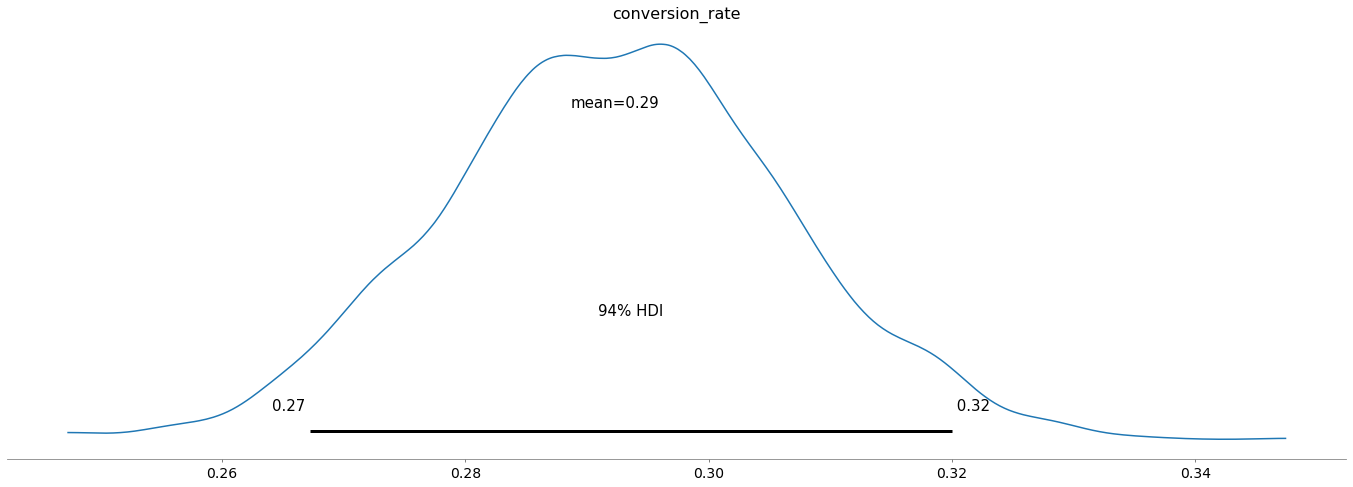

In [118]:
fig, ax = plt.subplots(figsize=(24, 8))
az.plot_posterior(idata.posterior, ax=ax);

With that PyMC combines the prior distribution, likelihood distribution, and data together and is able to estimate our hidden conversion rate that we set at the start of the lesson!

## Everything all together

In [62]:
# Generate random data to see if we can recover parameters in this lesson
np.random.seed(3)
n_visitors = 1000
conversion_rate=.3

# Simulate 1000 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

      
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # The magic inference Button
    idata = pm.sample()
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


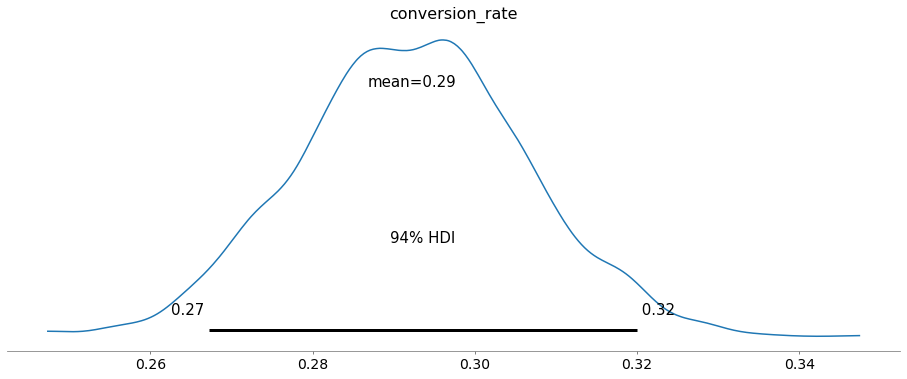

In [63]:
fig, ax = plt.subplots(figsize=(24, 8))
az.plot_posterior(idata.posterior, ax=ax);

To show you that I don't have any tricks up my sleeve let's do this together. In the first step we'll set some parameters and simulate some data. This way we know what the true conversion rate is, and we can see if we can recover it using our model.

We then code our model, starting with the model context, then our prior, likelihood, and sampler. Now that we've fully built our magic machine lets hit the magic inference button. With our MCMC samples done lets plot our posterior and see what we get!

Awesome, we're really close to the true conversion rate, definitely close enough for practical purposes. 



# Change the prior and data and see the effects
Download this notebook and change the prior and data and see what happens. Try using
* A wide prior
* More observations
* Less observations
* Different level of conversions

One of your exercises will be to simulate data, share that data is a discourse post, and see if someone else can recover the true p value, so hope you were paying attention!



<center> <img src="img/Congrats.gif" width="1200"> </center>

At this point you know now how to put together the magic machine and all the pieces of it! This honestly is a huge accomplishment, most people don't get to this depth of understanding but you have.

With this deep knowledge you'll be incredibly adept at specifying, understanding, and working with bayesian models, making you that Bayesian ninja.

# Section Recap
* Posterior distributions 
    * allow us to perform *inference* the goal of statistics
    * incorporate the data, the model, and our priors
* Bayesian updating is the process of combining prior, likelihood, data
* Posterior estimation is not always "easy or straightforward"
    * PPLs typically estimate the posterior with a sampling technique called MCMC 

# Prior and Posterior distributions
From parameter space to observed/data space

$$
\overbrace{p(\boldsymbol{Y}^\ast) =  \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y^\ast} \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta}) \; d\boldsymbol{\theta}}^{Prior Predictive Distribution}
$$

$$
\underbrace{p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta} \mid \boldsymbol{Y}) \, d\boldsymbol{\theta}}_{Posterior Predictive Distribution}
$$


<center> <img src="img/PredictiveDistributions.png" width="1200"> </center>

So far with prior, and posterior we've been in parameter space, estimating conversion rate, but if we want to know how many people we believe will convert, that is what we will observe, we'll need to flip from parameter space to observed, or data, space

## Prior Predictive Distribution

In [70]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("num_conversions", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    prior_a = pm.sample_prior_predictive()
   

In [23]:
# Live coded in the recording
prior_a

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

How do we show what our beliefs are in data space before we see any data? That's the prior predictive.

Let's use PyMC to generate this its quite easy its only one line. Note we don't even need to sample posterior, remember this is the distribution *before* we incorporate any data.

Aside from the mathematics of a prior predictive another great feature of the prior predictive is that it helps us check if our model is specified correctly. Let's try running this

Oops theres an error in the model specification, did you catch it? We accidentally flipped the input parameters to our binomial likelihood. Good thing we caught it early.

## Plotting our Prior predictive

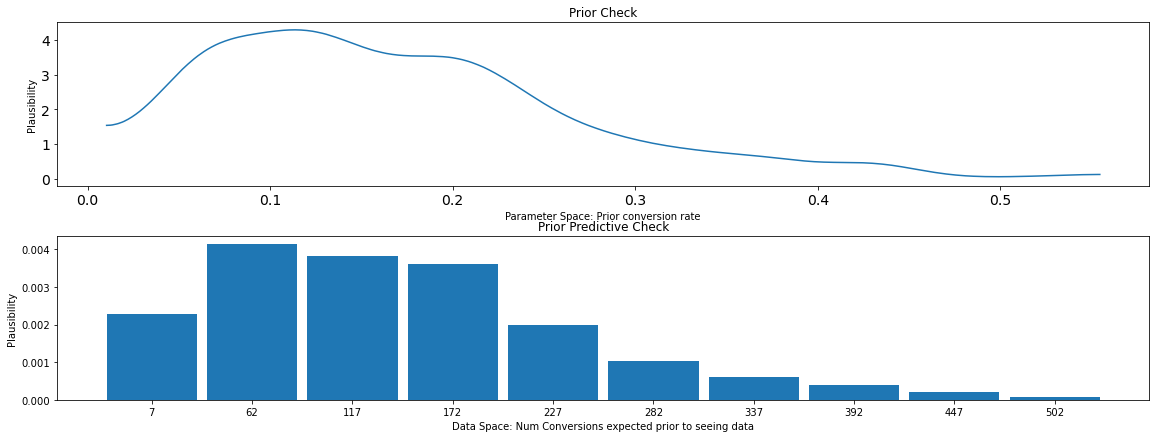

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=False)
az.plot_dist(prior_a.prior["conversion_rate"], ax=axes[0])
axes[0].set(
    xlabel="Parameter Space: Prior conversion rate",
    ylabel="Plausibility",
    title="Prior Check",
)

az.plot_dist(prior_a.prior_predictive["num_conversions"], ax=axes[1])
axes[1].set(
    xlabel="Data Space: Num Conversions expected prior to seeing data",
    ylabel="Plausibility",
    title="Prior Predictive Check",
)

fig.tight_layout();

Alright now we have our prior distribution and prior predictive. The top plot shows our prior belief in parameter space. We acn see most of the distribution mass is between 0 and 50% and there isn't much and the bottom shows it in data space, perfect for discussions with your boss who doesn't understand the Bayesian Matrix as well as you do.


## Posterior Predictive Distribution

In [65]:
# Simulate Data
np.random.seed(3)
n_visitors = 1000
conversion_rate=.3

# Simulate 1000 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

In [66]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("num_conversions", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    prior_a = pm.sample_prior_predictive(samples=10000)

    # The magic inference Button
    idata = pm.sample()
    idata.extend(prior_a)
    
    # Posterior Predictive
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The posterior predictive, as the name implies, uses the posterior to predict the future. We only need to add one extra line to generate a posterior predictive. Note how we pass in the idata which contains the posterior samples, unlike the prior predictive. 

This is because we need our posterior distribution for these prediction 

## Posterior Predictive Arrays

In [67]:
idata.posterior_predictive.num_conversions

<xarray.DataArray 'num_conversions' (chain: 4, draw: 1000)>
array([[285, 279, 298, ..., 268, 324, 292],
       [273, 253, 295, ..., 334, 306, 309],
       [306, 270, 285, ..., 276, 296, 303],
       [314, 317, 275, ..., 319, 313, 292]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

We get arrays of simulated futures, conditioned on the data!

So why is posterior predictive useful

* Sometimes were not interested in the parameters at all, but only what we believe will happen. You'll see that in the next lesson
* Other times we need to make a decision. Posterior predictive gives us not only the most likely future, but every single possible future weighted with the probability it will happen

This will be easier if we visualize it so let's jump to 

## Posterior and Posterior Predictive Plots

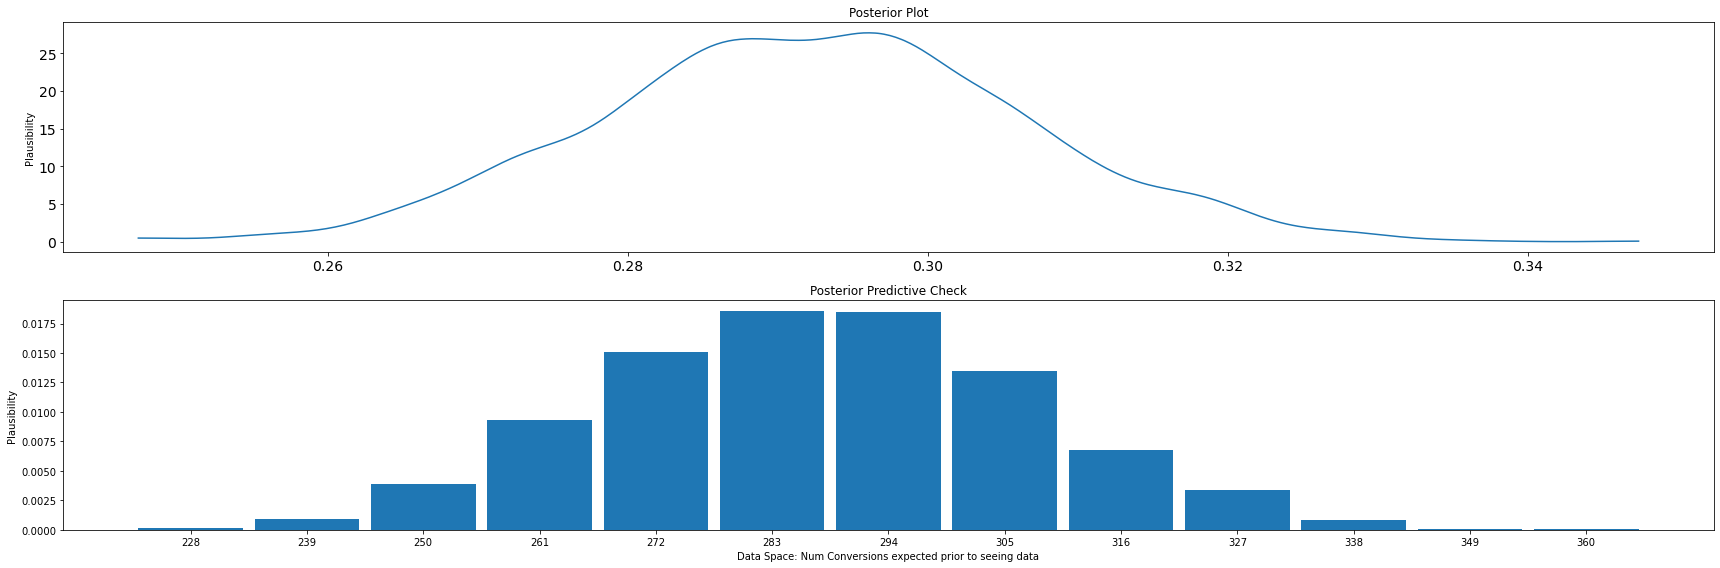

In [119]:
fig, axes = plt.subplots(2, 1, figsize=(24,8), sharex=False)
az.plot_dist(idata.posterior["conversion_rate"], ax=axes[0])
axes[0].set(ylabel="Plausibility", title="Posterior Plot")
az.plot_dist(idata.posterior_predictive["num_conversions"], ax=axes[1])

axes[1].set(xlabel="Data Space: Num Conversions expected prior to seeing data", 
       ylabel="Plausibility", 
       title="Posterior Predictive Check")

fig.tight_layout();

## Prior Predictive and Posterior Predictive Compared

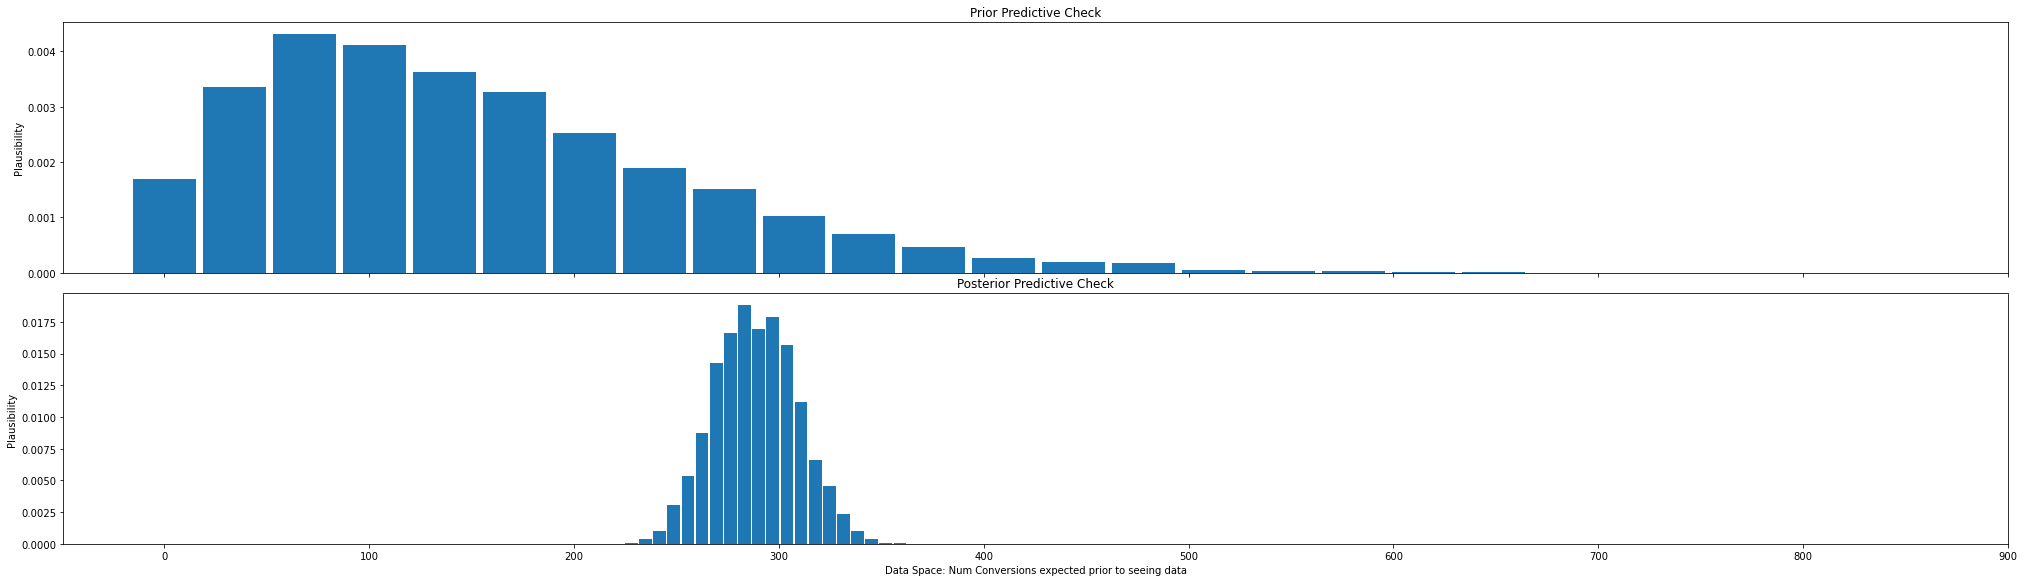

In [120]:
fig, axes = plt.subplots(2, 1, figsize=(28,8), sharex=True)
az.plot_dist(idata.prior_predictive["num_conversions"], hist_kwargs=dict(bins=20), ax=axes[0])

axes[0].set(ylabel="Plausibility", 
       title="Prior Predictive Check");fig.tight_layout()

az.plot_dist(idata.posterior_predictive["num_conversions"], hist_kwargs=dict(bins=20), ax=axes[1])
axes[1].set(xlabel="Data Space: Num Conversions expected prior to seeing data", 
       ylabel="Plausibility", 
       title="Posterior Predictive Check")

axes[1].set_xticks(np.arange(0,1000, 100));

Why is posterior predictive useful

* Sometimes were not interested in the parameters at all, but only what we believe will happen. You'll see that in the next lesson
* Other times we need to make a decision. Posterior predictive gives us not only the most likely future, but every single possible future weighted with the probability it will happen

<center><img src="img/GenerativeSamples.jpg" width="650"> </center>

These tools are possible because Bayesian models are generative, meaning they can generate outcomes. This is an incredible benefit over discriminative models, which can only fit existing data, but not generate new data

So if we didn't think computational Bayesian models were cool enough, this really should convince you. 


## Section Recap
* Predictive distributions are the link from parameter to data space\
* Two types
  * Prior Predictive
  * Posterior Predictive
* Many uses, both in modeling and Bayesian workflow
* Powerful feature of Bayesian Models
  * Easily implemented with one line of code

# Markov Chain Monte Carlo
The magic behind the magic inference button

## All you need to know
* Markov Chain Monte Carlo magic part of the magic machine
* It uses computational samples to estimate the posterior
* Modern versions are very flexible and very fast
  * Pay attention to the diagnostics though!

##  The magic inference button AKA Markov Chain Monte Carlo

It's using Markov Chain Monte which is a sampling based algorithm

* Works well on many models relatively automatically
* Is efficient and returns results relatively quickly
* Is pretty good at getting the right result
  * But if it can't comes with a good set of diagnostics to guide you


Building our own engine
* You will never need to do this
* The version we're building here is not good

In [27]:
# Manual calculation of the posterior
def post(θ, observed, α=1, β=1):
    if 0 <= θ <= 1:
        
        # Prior
        prior = stats.beta(α, β).pdf(θ)
        
        # Likellihood
        like  = stats.bernoulli(θ).pmf(observed).prod()
        
        # Multiplication
        prob = like * prior
    else:
        
        # If out of bounds 
        prob = -np.inf
    return prob

## Step by Step Instructions

1. Get the posterior value of where you are
2. Randomly select another parameter
3. Calculate posterior value at new parameter value
4. Calculate ratio of posterior values
5. Draw a random value from a uniform distribution
6. If value from uniform distribution is lower move to new position
   * Otherwise stay where you are and try again
   
 
Repeat many more times

## Step by Step Instructions in Code

In [ ]:
# n_iters = 10000
# can_sd = 0.05
# α = β =  1
# θ = 0.5

# trace = {"θ":np.zeros(n_iters)}
# p2 = post(θ, observed_visits, α, β)

# for iter in range(n_iters):

#     θ_can = stats.norm(θ, can_sd).rvs(1)
#     p1 = post(θ_can, observed_visits, α, β)
    
#     # This is why we don't need marginal likelihood!
#     pa = p1 / (p2)
        
#     if pa > stats.uniform(0, 1).rvs(1):
#         θ = θ_can
#         p2 = p1

#     trace["θ"][iter] = θ

Here's what the algorithm looks like for the most basic version of this algorithm. It's the same steps as the one above but in code. It actually works, feel free to try it out know its very  slow.

One interesting thing to note. You likely were wondering why we didn't cover marginal likelihood earlier in this lesson. Well its because its very hard to calculate, its actually so hard to calculate that one of the most important features of MCMC is we don't need to calculate it at all. See this one line here. By dividing out our posterior the marginal likelihood actually cancels out. This small mathematical trick is a massive achievement so don't take it for granted!

## Original Version: Metropolis Hasting
<center> <img src="img/OldCar.png" width="1200"> </center>

That's because what we've implemented here is a version of MCMC called Metropolis Hastings. It's one of the initial versions of MCMC and like this car here. while it works it's it slow, inefficient, and tends to require a lot of hand tuning to get it to work juuusstt right

## Modern Speed Machine: HMC
<center> <img src="img/Formula1Car.png" width="900"> </center>

Modern PPls like PyMC use a much better version of MCMC called Hamiltonian Monte Carlo, or HMC for short. Thats why you you see the line "Using NUTS" after running `pm.sample` in sample in PyMC

Like this F1 car it still uses the original principle, but has additional updates and systems that make it wayyy faster and easier to use.



## MCMC Sampling in Action
<br>
<center> <video src="img/SamplerVideo.mp4" width="1500"/></center>

Here is a video of MCMC in action. Its about a minute long, lets take a moment to talk through what's happening.

* Samples stacking up
* How the dots fall not totally but move right to left, but also not totally consistently
* How a normal distribution is taking shape

## Trace Plot

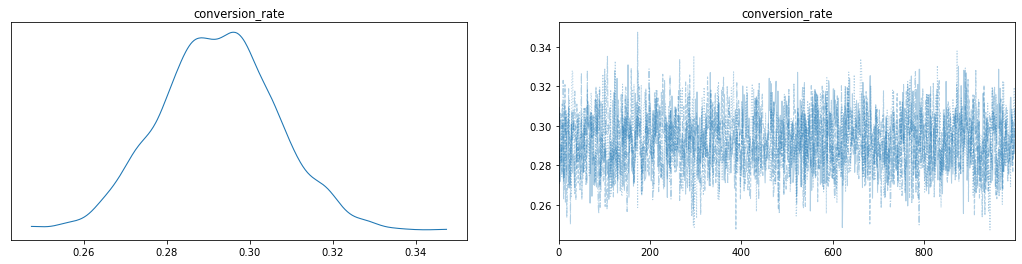

In [90]:
az.plot_trace(idata, combined=True, figsize=(18,4));

That's what you see on the right on the trace plot. As the name implies its tracing the samples. With MCMC based inference you'll see traceplots often. That's because they're a key diagnostic to ensure sampling is working as expected.

The X axis integer number of the draw, and the Y axis is the value of the sample at that draw. The reason you see so many lines is that we don't just sample with chain of samples, but typically multiple at once. What we're looking for is a "fuzzy caterpillar", this indicates the samples are coming from the full distribution of the posterior and aren't stuck in one place. You'll see more traceplots later in this course.

## Section Summary
* Markov Chain Monte Carlo magic part of the magic machine
* It uses computational samples to estimate the posterior
* Modern versions are very flexible and very fast
  * Still requires checking with diagnostics

# Lesson Summary
Unfinished for now

* The three terms we care about in Bayes Rule
  * And the one we don't
* The different types of priors
  * Informative 
  * Uninformative
* How to calculate likelihood given data
* How to calculate a simple posterior